In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from dtaidistance import dtw, dtw_c, dtw_ndim
from numpy.random import choice, shuffle
from torch import nn
from sklearn.model_selection import train_test_split
from scipy.stats import zscore

from torch.utils.data import DataLoader, TensorDataset, random_split

In [35]:
%load_ext autoreload
%autoreload 1

from preprocessing import *
from models import Encoder, Decoder, Sequence2Sequence

%aimport preprocessing
%aimport models

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Example of multidimensional time-series

In [36]:
# !mkdir -p data
# !wget https://www.cs.ucr.edu/%7Eeamonn/time_series_data_2018/UCRArchive_2018.zip ../data
# !unzip data/UCRArchive_2018.zip -d ../data

In [37]:
# data_path = "../data/UCRArchive_2018/Earthquakes/Earthquakes_TRAIN.tsv"

In [38]:
# data = pd.read_csv(data_path, header=None, delimiter="\t").values

# # to remove Nan (only first columns)
# data = data[:, ~np.isnan(data).any(0)]

# X = data[:, 1:]
# y = data[:, 0].astype(np.short)

# B_Accelerometer preprocessing

[Link](https://github.com/mmalekzadeh/motion-sense/blob/master/data/B_Accelerometer_data.zip "")

In [39]:
import os

def get_dataset_2(length):
    LABELS = [0, 1, 4, 5]

    labels = np.unique([x[:3] for x in os.listdir("../data/B_Accelerometer_data/")])
    dirs = os.listdir("../data/B_Accelerometer_data/")
    d = dict((label, i) for (i, label) in enumerate(labels))

    timeseries = {label: [] for label in d.values()}

    for dir_name in dirs:
        tmp = []
        for f in os.listdir("../data/B_Accelerometer_data/{}".format(dir_name)):
            data = pd.read_csv("../data/B_Accelerometer_data/{}/{}".format(dir_name, f), index_col=0)

            tmp.append(np.linalg.norm(data, axis=1))

        timeseries[d[dir_name[:3]]] = zscore(np.hstack(tmp))

    dataset = {label: [] for label in LABELS}
    for label in LABELS:
        X = timeseries[label][np.newaxis].T
        dataset[label].extend(slice_timeseries(X, length))


    max_count = min([len(x) for x in dataset.values()])
    for label, ts in dataset.items():
        dataset[label] = [ts[idx] for idx in choice(range(len(ts)), max_count, replace=False)]

    X = np.array([zscore(x) for _, ts in dataset.items() for x in ts])
    y = [np.repeat(label, len(ts)) for label, ts in dataset.items()]
    X = np.hstack(X).T
    y = np.hstack(y).T
    
    return X, y

In [40]:
# fig, axs = plt.subplots(len(LABELS), figsize=(10, 15))

# for i, label in enumerate(LABELS):
#     axs[i].plot(dataset[label][10])

# Accelerometer dataset 

- 1: Working at Computer
- 2: Standing Up, Walking and Going up\down stairs
- 3: Standing
- 4: Walking
- 5: Going Up\Down Stairs
- 6: Walking and Talking with Someone
- 7: Talking while Standing

In [41]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00287/Activity%20Recognition%20from%20Single%20Chest-Mounted%20Accelerometer.zip -O ../data/Accelerometer.zip
# ! unzip ../data/Accelerometer.zip -d ./data

In [42]:
CHANNELS = ['0', '1', '2']
LABELS = [1, 3, 4, 5]

LENGTH = 100
start_ident = 200

In [43]:
def get_dataset_3():
    np.random.seed(0)


    dataset = {label: [] for label in LABELS}

    for i in range(1, 11):
        data_path = "../data/Activity Recognition from Single Chest-Mounted Accelerometer/{0}.csv".format(i)
        data = pd.read_csv(data_path,
                       names=['0', '1', '2', "labels"],
                       index_col=0,
                       dtype=np.float)

        for label in LABELS:
            X = get_class_timeseries(label, data, start_ident)
            X = np.linalg.norm(X, axis=1)[np.newaxis].T
            dataset[label].extend(slice_timeseries(X, LENGTH))

    max_count = min([len(x) for x in dataset.values()])
    for label, ts in dataset.items():
        dataset[label] = [ts[idx] for idx in choice(range(len(ts)), max_count, replace=False)]

    X = np.array([zscore(x) for _, ts in dataset.items() for x in ts])
    y = [np.repeat(label, len(ts)) for label, ts in dataset.items()]
    X = np.hstack(X).T
    y = np.hstack(y).T
    
    return X, y

# Experiment

In [45]:
device = torch.device("cuda")

def prepare_data(X, y, k, w):
    ds = SplittedDataset(X, y, k, w, device=device)
    train_ds, test_ds, valid_ds = train_test_valid_split(ds, 0.3, 0.2)

    train_set = DataLoader(train_ds, batch_size=1024, shuffle=True)
    test_set = DataLoader(test_ds, batch_size=1024, shuffle=True)
    valid_set = DataLoader(valid_ds, batch_size=256, shuffle=True)
    
    return train_set, test_set, valid_set

In [46]:
from models import Encoder, Decoder, Sequence2Sequence

input_dim = 2*k
hidden_dim = 10
n_layers = 5

def get_model(hidden_dim, k, n_layers):
    input_dim = 2*k
    enc = Encoder(input_dim, hidden_dim, 1, n_layers, False)
    dec = Decoder(hidden_dim, input_dim, 1, n_layers)

    model = Sequence2Sequence(enc, dec)
    model.to(device)
    
    return model

In [ ]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(model.parameters())

In [60]:
def train(model, train_ds, optim, valid_ds, n_step):
    model.train()
    for step in range(n_step):
        it = iter(train_ds)
        for batch, _, _ in it:
            batch = batch.permute(1, 0, 2)
            optim.zero_grad()
            out = model(batch)
            loss = loss_fn(batch, out)

            if step % 500 == 0:
                print("Loss: {:.3f}".format(loss.cpu().detach().numpy()))

            loss.backward()
            optim.step()

            if step % 1000 == 0:
                valid(model, valid_ds)
                model.train()

def valid(model, valid_ds):
    model.eval()
    with torch.no_grad():
        loss = 0.
        it = iter(valid_ds)
        for batch, _, _ in it:
            batch = batch.permute(1, 0, 2)
            out = model(batch)
            loss += loss_fn(batch, out)
    
    print("Valid loss: {:.3f}".format(loss.cpu().detach().numpy()))

In [54]:
# model.load_state_dict(torch.load("../data/pretrained.pcl"))

In [88]:
from time import time
from sklearn.neighbors import KNeighborsClassifier

def m(id1, id2, matrix):
    x, y = int(min(id1[0], id2[0])), int(max(id1[0], id2[0]))
    return matrix[x, y]

def get_metric(matrix):
    return lambda id1, id2: m(id1, id2, matrix)

def workflow(w, k, hidden_dim, n_layers, length, n_step=6000):
    X, y = get_dataset_2(length)
    train_set, test_set, valid_set = prepare_data(X, y, k, w)
    model = get_model(hidden_dim, k, n_layers)
    loss_fn = nn.MSELoss()
    optim = torch.optim.Adam(model.parameters())
    train(model, train_set, optim, test_set, n_step)
    torch.save(model.state_dict(), "../data/w={};k={};nl={};length={}".format(w, k, n_layers, length))
    valid(model, test_set)
    valid_it = iter(valid_set)
    batch, timeseries, labels = next(valid_it)
    timeseries = timeseries.numpy()

    scores_ts = []
    scores_hidden = []

    t = time()
    matrix_ts = dtw.distance_matrix(timeseries, use_c=True)
    print("raw_ts: {:.3f}".format(time() - t))
    t = time()
    hiddens = model.encoder(batch.permute(1, 0, 2))[0].permute(1, 0, 2).detach().cpu().numpy()
    matrix_hidden = dtw_ndim.distance_matrix(hiddens)
    print("hidden_ts: {:.3f}".format(time() - t))
    idxs = np.arange(len(timeseries)).reshape(-1, 1)

    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(idxs, labels.cpu().numpy(), test_size=0.4)

        clf = KNeighborsClassifier(metric=get_metric(matrix_ts), algorithm="brute")
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        scores_ts.append(score)
        clf = KNeighborsClassifier(metric=get_metric(matrix_hidden), algorithm="brute")
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        scores_hidden.append(score)

    print("{:.3f}".format(np.mean(scores_ts)))    
    print("{:.3f}".format(np.mean(scores_hidden)))

In [ ]:
LENGTHS = [100]
W = [3, 5, 7]
K = [3, 5, 7]
HIDDEN_DIM = [4, 6]
N_LAYERS = [1, 2, 4]

for w in W:
    for k in K:
        for length in LENGTHS:
            for hidden_dim in HIDDEN_DIM:
                for n_layers in N_LAYERS:
                    print("{:#^80}".format(" w={}; k={}; hidden={}; nl={} ".format(w, k, hidden_dim, n_layers)))
                    workflow(w, k, hidden_dim, n_layers, length, 2000)

# See decodered peaces of timeseries

In [95]:
id0 = 5
id1 = 5
w = 3
k = 5
hidden_dim = 6
length = 100
X, y = get_dataset_2(length)
n_layers = 1
train_set, test_set, valid_set = prepare_data(X, y, k, w)
model = get_model(hidden_dim, k, n_layers)
valid_it = iter(valid_set)
batch, timeseries, labels = next(valid_it)
timeseries = timeseries.numpy()
model.load_state_dict(torch.load("../data/w={};k={};nl={};length={}".format(w, k, n_layers, length)))

x_out = model(batch.permute(1, 0, 2)).permute(1, 0, 2).cpu().detach().numpy()

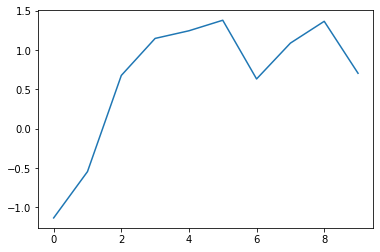

In [96]:
plt.plot(batch[id0, id1].cpu())

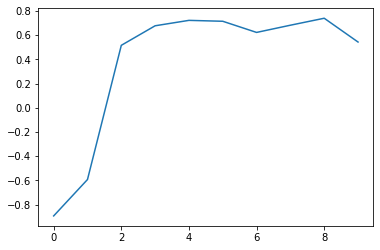

In [97]:
plt.plot(x_out[id0, id1])

## Classification on raw time-series

In [ ]:
%%time
matrix_ts = dtw.distance_matrix(timeseries, use_c=True)

In [ ]:
clf = KNeighborsClassifier(metric=get_metric(matrix_ts), algorithm="brute")
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
score

## Hidden states classification

In [ ]:
%%time
hiddens = model.encoder(batch.permute(1, 0, 2))[0].permute(1, 0, 2).detach().cpu().numpy()
matrix_hidden = dtw_ndim.distance_matrix(hiddens)

In [ ]:
clf = KNeighborsClassifier(metric=get_metric(matrix_hidden), algorithm="brute")
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
score

# Statistic

In [ ]:
scores_ts = []
scores_hidden = []

for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(idxs, labels.cpu().numpy(), test_size=0.3)

    clf = KNeighborsClassifier(metric=get_metric(matrix_ts), algorithm="brute")
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scores_ts.append(score)
    clf = KNeighborsClassifier(metric=get_metric(matrix_hidden), algorithm="brute")
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scores_hidden.append(score)
    
print("{:.3f}".format(np.mean(scores_ts)))    
print("{:.3f}".format(np.mean(scores_hidden)))